In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
def get_col(fn, col_name):
    df = pd.read_csv(fn)
    return df[col_name].values

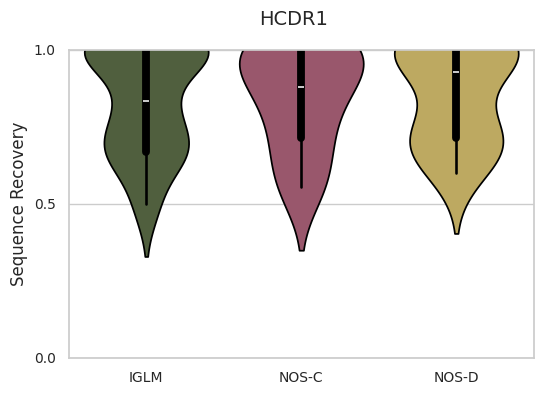

In [93]:
iglm_fn = 'data/iglm_fixed_samples_labeled_hcdr1.csv'
iglm_data = get_col(iglm_fn, 'seq_recovery')
iglm_med = np.median(iglm_data)

nosc_fn = 'data/gaussian_fixed_length=True_samples_labeled_hcdr1.csv'
nosc_data = get_col(nosc_fn, 'seq_recovery')
nosc_med = np.median(nosc_data)

nosd_fn = 'data/mlm_fixed_length=True_samples_labeled_hcdr1.csv'
nosd_data = get_col(nosd_fn, 'seq_recovery')
nosd_med = np.median(nosd_data)

data_violin = {
    'IGLM': iglm_data,
    'NOS-C': nosc_data,
    'NOS-D': nosd_data
}

data_bar = {
    'Algorithm': ['IGLM', 'NOS-C', 'NOS-D'],
    'Median Sequence Recovery': [iglm_med, nosc_med, nosd_med]
}

fig, axes = plt.subplots(1, 1, figsize=(6, 4))

group_names = []
values = []
for group, samples in data_violin.items():
    group_names.extend([group] * len(samples))
    values.extend(samples)

df_v = pd.DataFrame({"Algorithm": group_names, "Sequence Recovery": values})
sns.violinplot(x='Algorithm', y='Sequence Recovery', data=df_v, inner='box', palette=['#506538', '#A44C68', '#CCB252'], hue='Algorithm', linecolor='black', ax=axes)
axes.set_ylim(top=1)
axes.set_xlabel('')
axes.set_ylabel('Sequence Recovery', fontsize=12)
axes.tick_params(axis='both', which='major', labelsize=10)
axes.set_yticks(np.linspace(0, 1, 3))

fig.suptitle('HCDR1', fontsize=14)

plt.show()


In [186]:
lambda_params = [10.0, 1.0, 0.1, 0.01, 0.001]
mu_params = [1.0]
K_params = [10]

nosd_ll = []
nosc_ll = []
nosd_beta_sheet = []
nosc_beta_sheet = []
data_map = {
    "mlm_ll" : nosd_ll,
    "gaussian_ll": nosc_ll,
    "mlm_beta_sheet": nosd_beta_sheet,
    "gaussian_beta_sheet": nosc_beta_sheet
}

for lam in lambda_params:
    for mu in mu_params:
        for K in K_params:
            curr = {}
            for nos in ["mlm", "gaussian"]:
                guid_fn = f"/home/shai/NOS/guidance_results/{nos}/{nos}_fixed_length=True_autoregressive_sample=False_step_size={mu}_stability_coef={lam}_num_steps={K}_guidance_layer=first_return_best=True_samples_labeled.csv"
                try:
                    ll = -get_col(guid_fn, 'lm_nll')
                    beta_sheet = get_col(guid_fn, 'ss_perc_sheet')
                except FileNotFoundError as e:
                    continue
                med_ll = np.median(ll)
                med_beta = np.median(beta_sheet)
                data_map[nos + "_ll"].append(float(med_ll))
                data_map[nos + "_beta_sheet"].append(float(med_beta))

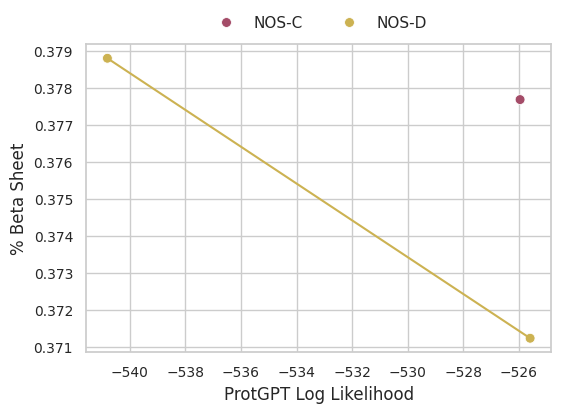

In [187]:
data = {
    "ProtGPT Log Likelihood": nosd_ll + nosc_ll,
    "% Beta Sheet": nosd_beta_sheet + nosc_beta_sheet,
    "Algorithm": ["NOS-C"] * len(nosc_ll) + ["NOS-D"] * len(nosd_ll)
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))

ax = sns.scatterplot(data=df, x="ProtGPT Log Likelihood", y="% Beta Sheet", hue="Algorithm", palette=['#A44C68', '#CCB252'], s=50)
sns.lineplot(data=df, x="ProtGPT Log Likelihood", y="% Beta Sheet", hue="Algorithm", palette=['#A44C68', '#CCB252'], legend=False)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title='', frameon=False)

plt.tick_params(axis='both', which='major', labelsize=10, )
plt.show()
